In [39]:
import pyorc
import matplotlib.pyplot as plt
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from dask.diagnostics import ProgressBar
from matplotlib import patches

In [40]:
cam_config = pyorc.load_camera_config("Outputs/BR.json")
video_file =  r"../Videos/bridge_main_1.MP4"
# set coordinates that encapsulate the water surface at minimum. Areas outside will be used for stabilization
stabilize = [
    [250 ,600],   # bottom left
    [500 , 400],   #  top left 
    [1400 , 400],    # top right
    [1500 , 600]     # bottom right
]
video = pyorc.Video(
    video_file,
    camera_config=cam_config,
    start_frame=0,
    end_frame=10,
    stabilize=stabilize,

)
video


Scanning video: 100%|██████████| 11/11 [00:03<00:00,  3.30it/s]
Deriving stabilization parameters from second frame onwards: 100%|██████████| 10/10 [00:02<00:00,  3.56it/s]



Filename: ../Videos/bridge_main_1.MP4
FPS: 25.000000
start frame: 0
end frame: 10
Camera configuration: {
    "height": 1080,
    "width": 1920,
    "crs": "PROJCRS[\"WGS 84 / UTM zone 43N\",BASEGEOGCRS[\"WGS 84\",ENSEMBLE[\"World Geodetic System 1984 ensemble\",MEMBER[\"World Geodetic System 1984 (Transit)\"],MEMBER[\"World Geodetic System 1984 (G730)\"],MEMBER[\"World Geodetic System 1984 (G873)\"],MEMBER[\"World Geodetic System 1984 (G1150)\"],MEMBER[\"World Geodetic System 1984 (G1674)\"],MEMBER[\"World Geodetic System 1984 (G1762)\"],MEMBER[\"World Geodetic System 1984 (G2139)\"],MEMBER[\"World Geodetic System 1984 (G2296)\"],ELLIPSOID[\"WGS 84\",6378137,298.257223563,LENGTHUNIT[\"metre\",1]],ENSEMBLEACCURACY[2.0]],PRIMEM[\"Greenwich\",0,ANGLEUNIT[\"degree\",0.0174532925199433]],ID[\"EPSG\",4326]],CONVERSION[\"UTM zone 43N\",METHOD[\"Transverse Mercator\",ID[\"EPSG\",9807]],PARAMETER[\"Latitude of natural origin\",0,ANGLEUNIT[\"degree\",0.0174532925199433],ID[\"EPSG\",8801]],PARA

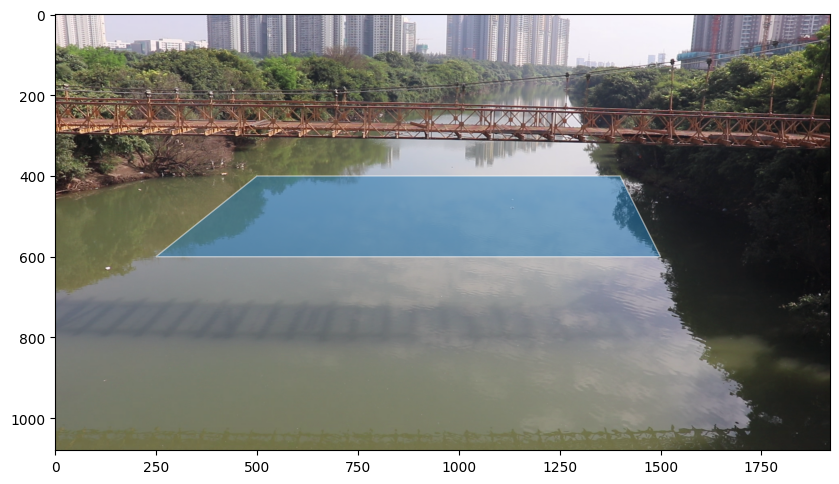

In [41]:
# some keyword arguments for fancy polygon plotting
patch_kwargs = {
    "alpha": 0.5,
    "zorder": 2,
    "edgecolor": "w",
    "label": "Area of interest",
}
f, ax = plt.subplots(1, 1, figsize=(10, 6))

frame = video.get_frame(0, method="rgb")
# plot frame on a notebook-style window
ax.imshow(frame)
# add the polygon to the axes
patch = patches.Polygon(
    stabilize,
    **patch_kwargs
)
p = ax.add_patch(patch)

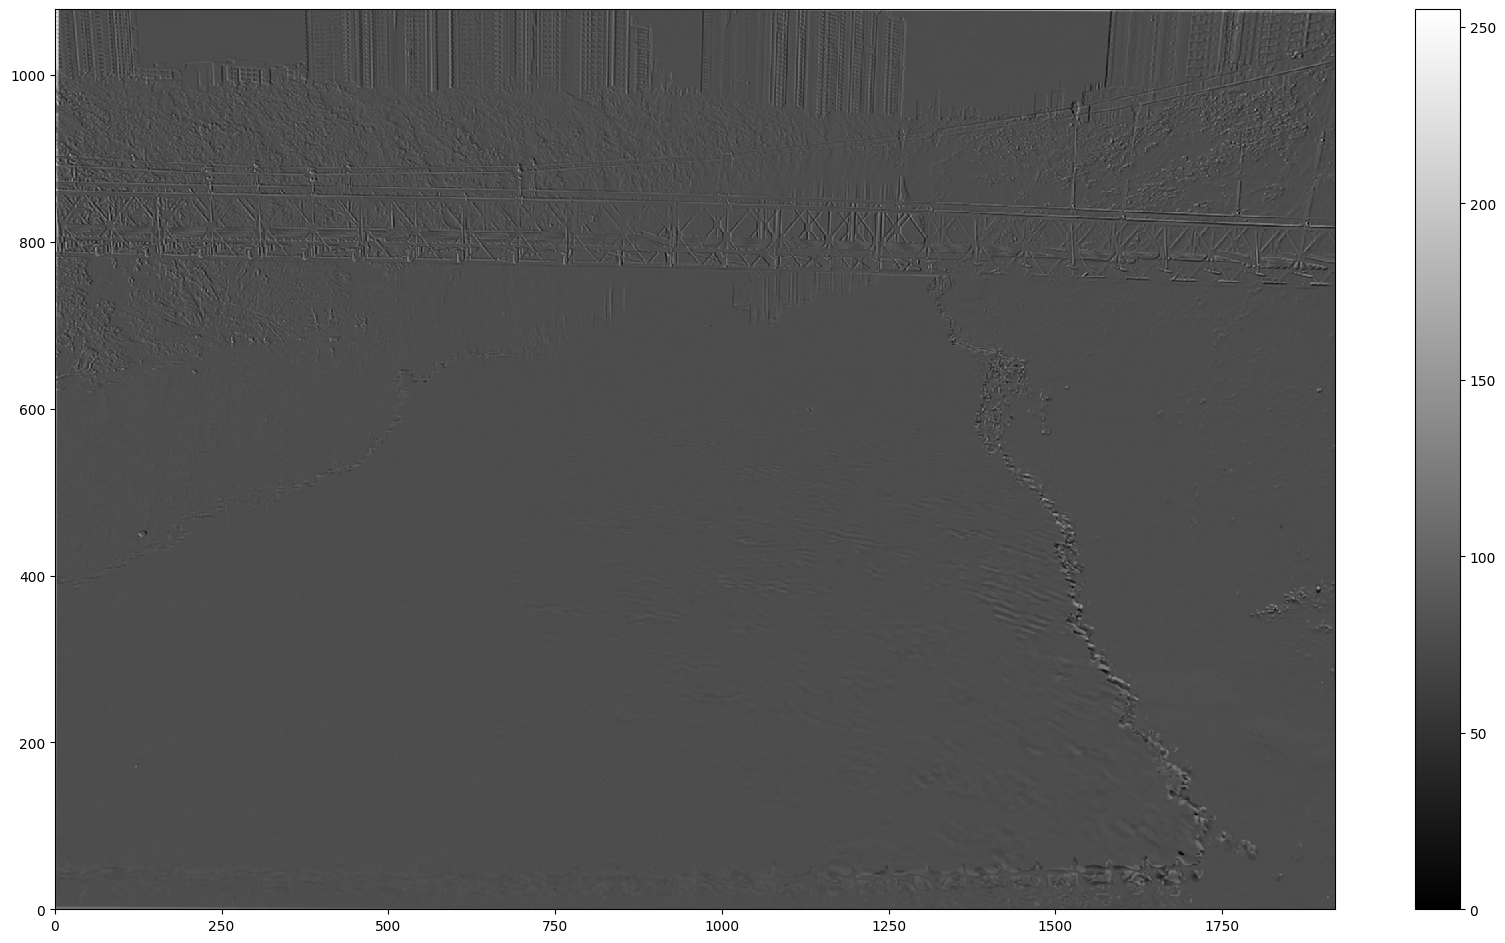

In [47]:
da = video.get_frames()
#da[0].frames.plot(cmap="gray")

#da_norm = da.frames.time_diff(abs=False, thres=0.)
#da_norm = da_norm.frames.minmax(min=0.)
da_norm = da.frames.normalize()
p = da_norm[0].frames.plot(cmap="gray")
plt.colorbar(p)


<Figure size 1600x900 with 0 Axes>

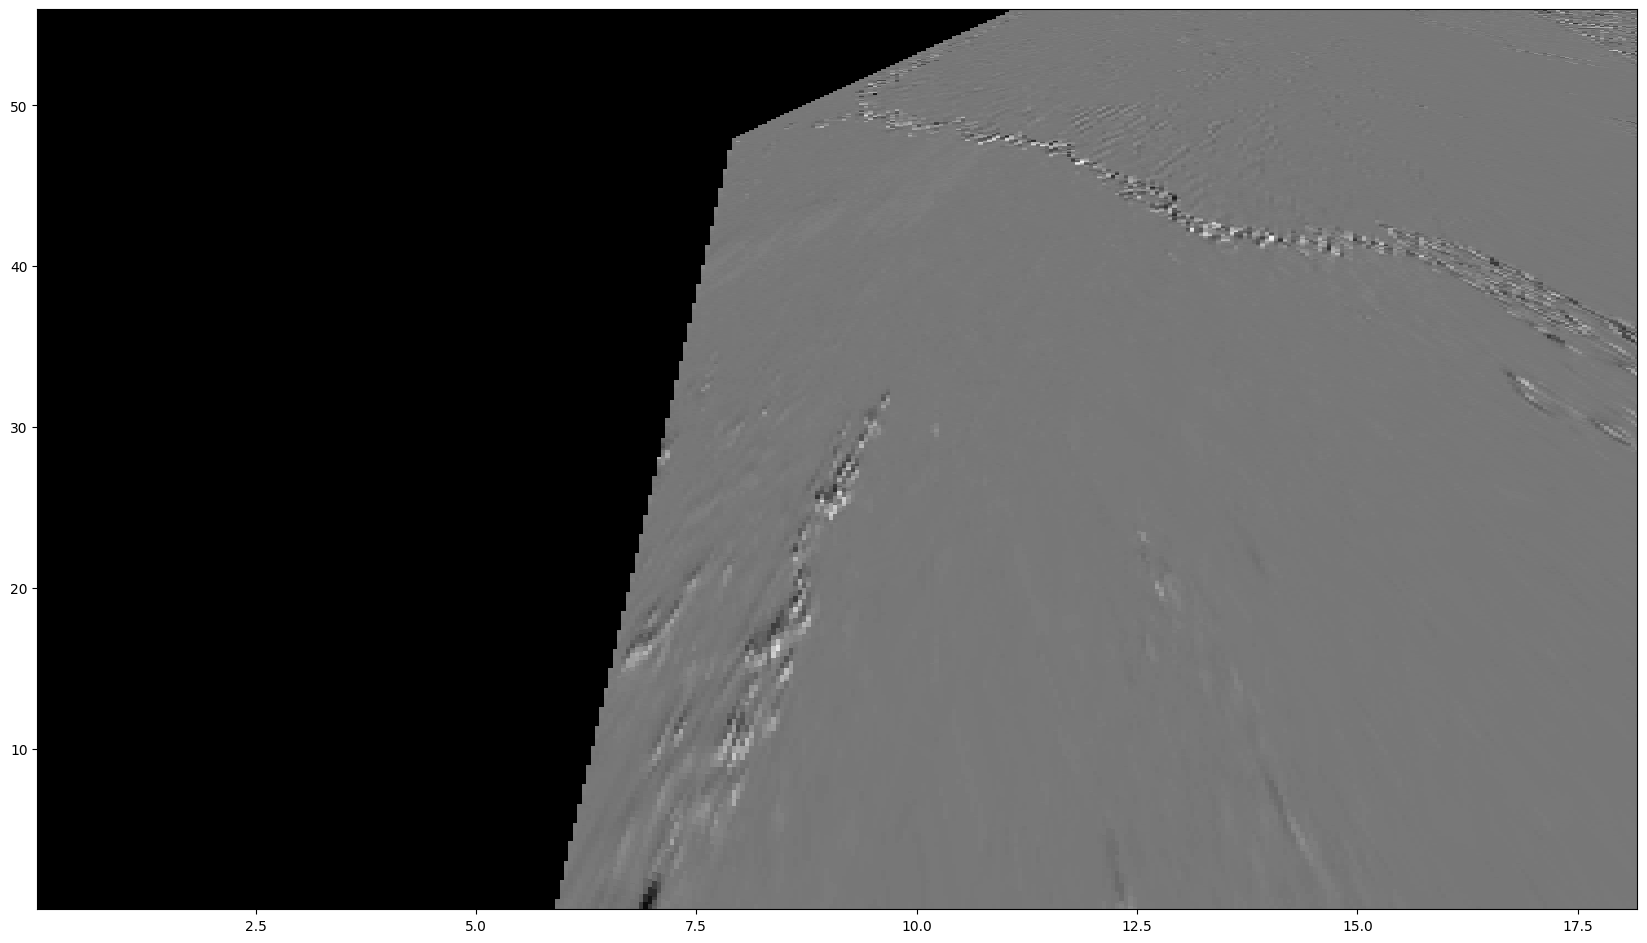

In [48]:
f = plt.figure(figsize=(16, 9))
da_norm_proj = da_norm.frames.project(method="numpy")
da_norm_proj[0].frames.plot(cmap="gray")

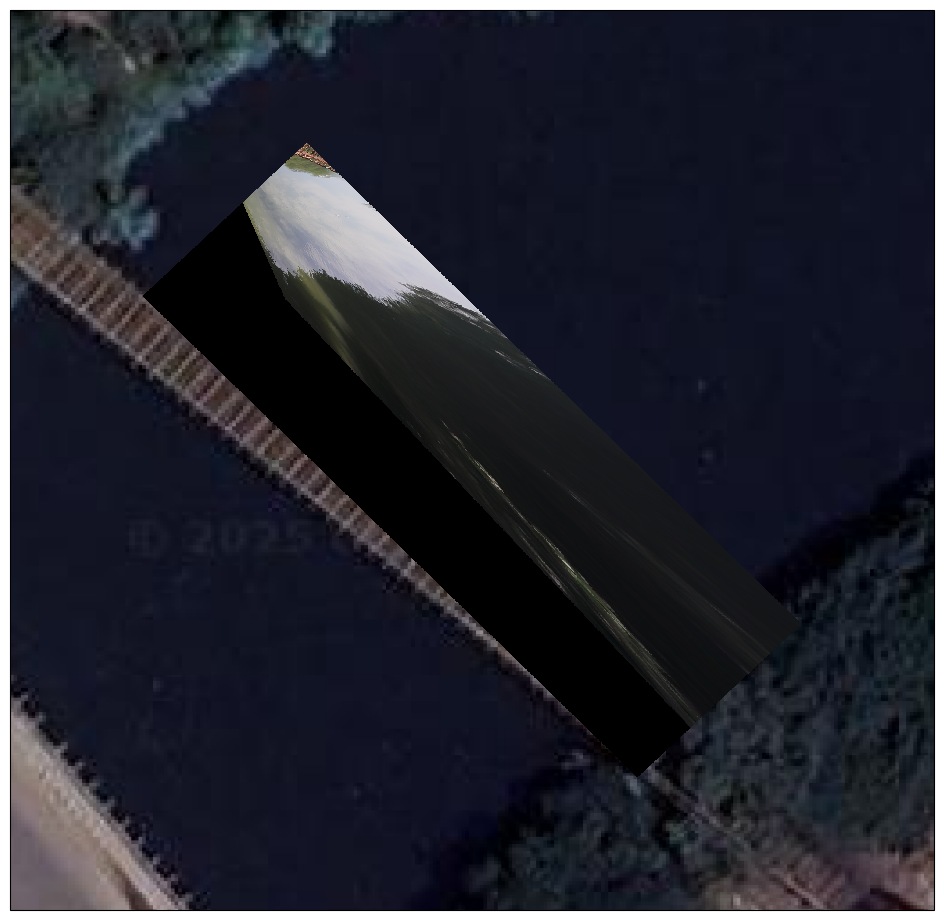

In [49]:
# extract frames again, but now with rgb
da_rgb = video.get_frames(method="rgb")
# project the rgb frames, same as before
da_rgb_proj = da_rgb.frames.project()
# plot the first frame in geographical mode
p = da_rgb_proj[0].frames.plot(mode="geographical")

# for fun, let's also add a satellite background from cartopy
import cartopy.io.img_tiles as cimgt
import cartopy.crs as ccrs
tiles = cimgt.GoogleTiles(style="satellite")
p.axes.add_image(tiles, 19)
# zoom out a little bit so that we can actually see a bit
p.axes.set_extent([
    da_rgb_proj.lon.min() - 0.0001,
    da_rgb_proj.lon.max() + 0.0001,
    da_rgb_proj.lat.min() - 0.0001,
    da_rgb_proj.lat.max() + 0.0001],
    crs=ccrs.PlateCarree()
)

In [51]:
# 1. Set the water level attribute (as a STRING that can be parsed as a float/JSON)
# !! Change your setting line to include the string quotes !!
da_norm_proj.attrs['h_a'] = '0.75' # Changed to a string!

# 2. Run the PIV calculation (This should now pass the JSON parsing)
piv = da_norm_proj.frames.get_piv(engine="numba")

# 3. Remove the problematic attribute before saving (Still a good practice)
if 'h_a' in piv.attrs:
    del piv.attrs['h_a']

# 4. Save the result
piv.to_netcdf("Outputs/BR.nc")

Computing PIV per chunk: 100%|██████████| 1/1 [00:14<00:00, 14.64s/it]
